## Load Initial Data

In [2]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

seasons = range(2018, 2024 + 1)
pbp_py = nfl.import_pbp_data(seasons)

## Look at just pass plays and exlude nulls
pbp_py_pass =\
    pbp_py\
    .query('play_type == "pass" & passer_id.notnull() & air_yards.notnull()')\
    .reset_index()
    

2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


## Refine and get first look at data

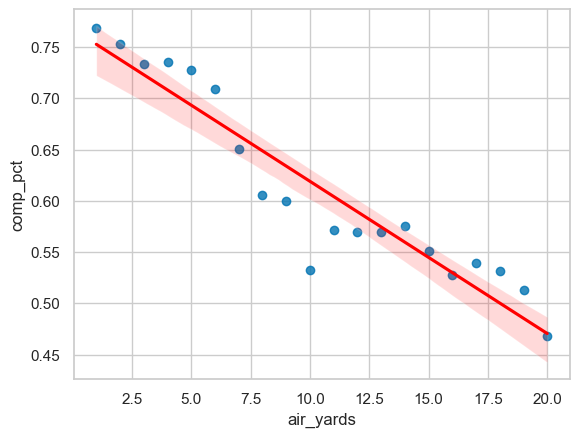

In [9]:
## Further refine data to use
sns.set_theme(style = 'whitegrid', palette = 'colorblind')

pass_pct_py =\
    pbp_py_pass\
    .query('0 < air_yards <= 20')\
    .groupby('air_yards')\
    .agg({'complete_pass': ['mean']})

pass_pct_py.columns =\
    list(map('_'.join, pass_pct_py.columns))

pass_pct_py\
    .reset_index(inplace = True)
pass_pct_py\
    .rename(columns = {'complete_pass_mean': 'comp_pct'},
               inplace = True)
sns.regplot(data = pass_pct_py, x = 'air_yards', y = 'comp_pct', line_kws = {'color': 'red'})

plt.show()

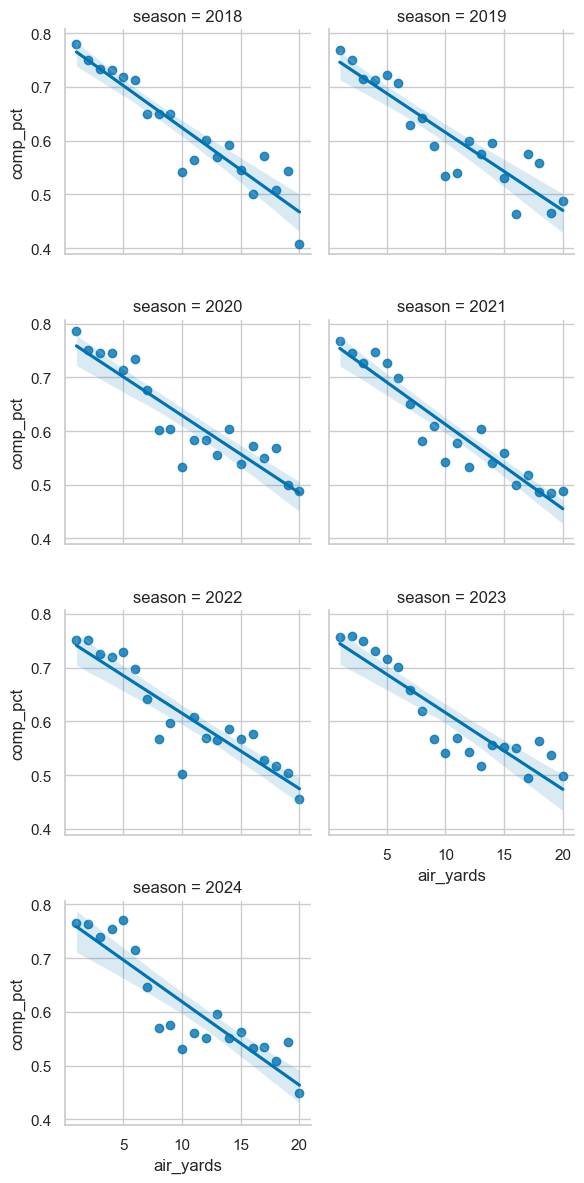

In [13]:
## Does the correlation change at all by year?
sns.set_theme(style = 'whitegrid', palette = 'colorblind')

pass_pct_py =\
    pbp_py_pass\
    .query('0 < air_yards <= 20')\
    .groupby(['season', 'air_yards'])\
    .agg({'complete_pass': ['mean']})

pass_pct_py.columns =\
    list(map('_'.join, pass_pct_py.columns))

pass_pct_py\
    .reset_index(inplace = True)
pass_pct_py\
    .rename(columns = {'complete_pass_mean': 'comp_pct'},
               inplace = True)
g =\
    sns.FacetGrid(data = pass_pct_py, col = 'season', col_wrap = 2, sharey = True)\
    .map_dataframe(sns.regplot, x = 'air_yards', y = 'comp_pct')

plt.show()

## Building a Generalized Linear Model

In [3]:
## Lets first look at a basic GLM to analyze how air yards can predict the liklihood of a pass being completed
complete_ay_py =\
    smf.glm(formula = 'complete_pass ~ air_yards',
           data = pbp_py_pass, 
           family = sm.families.Binomial())\
            .fit()

complete_ay_py.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          complete_pass   No. Observations:               130140
Model:                            GLM   Df Residuals:                   130138
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -79593.
Date:                Sat, 04 Jan 2025   Deviance:                   1.5919e+05
Time:                        13:16:46   Pearson chi2:                 1.31e+05
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07102
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0959      0.008    135.884      0.000       1.080       1.112
air_yards     -0.0576      0.001    -91.969      0.000      -0.059      -0.056
==============================================================================
"""

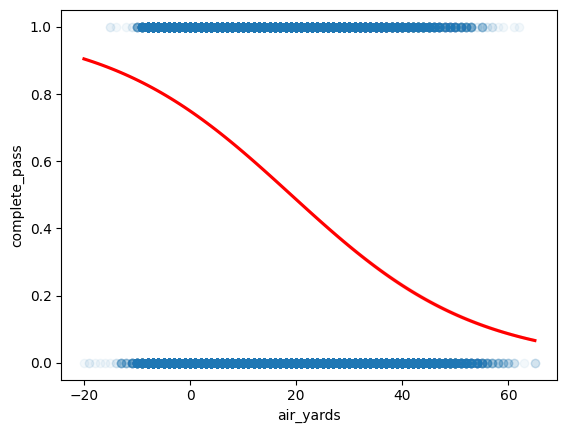

In [4]:
## Now create a logistic regression plot to visualize this data
sns.regplot(data = pbp_py_pass, x = 'air_yards', y = 'complete_pass',
            logistic = True,
            line_kws = {'color': 'red'},
           scatter_kws = {'alpha': 0.05})

plt.show()

## Apply the GLM to Completion Percentage for a QB

In [16]:
## Using the .predict() function to take the predicted value from the model above
pbp_py_pass['exp_completion'] =\
    complete_ay_py.predict()

pbp_py_pass['cpoe'] =\
    pbp_py_pass['complete_pass'] -\
    pbp_py_pass['exp_completion']

In [25]:
## Look at the top QBs by CPOE as well as their completion percentage

cpoe_py =\
    pbp_py_pass\
    .groupby(['season', 'passer_id', 'passer'])\
    .agg({'cpoe': ['count', 'mean'],
         'complete_pass': ['mean']})

cpoe_py.columns =\
    list(map('_'.join, cpoe_py.columns))
cpoe_py.reset_index(inplace = True)

cpoe_py =\
    cpoe_py.rename(columns = {'cpoe_count': 'n',
                             'cpoe_mean': 'cpoe',
                             'complete_pass_mean': 'compl'})\
        .query('n >= 100')

print(cpoe_py.sort_values('cpoe', ascending = False))

     season   passer_id               passer    n      cpoe     compl
107    2019  00-0020531              D.Brees  406  0.089440  0.756158
1      2018  00-0020531              D.Brees  566  0.081809  0.738516
275    2020  00-0033537             D.Watson  542  0.068861  0.704797
273    2020  00-0033357               T.Hill  121  0.067881  0.727273
142    2019  00-0029701          R.Tannehill  343  0.064258  0.690962
..      ...         ...                  ...  ...       ...       ...
568    2023  00-0032156            T.Siemian  153 -0.118748  0.562092
538    2022  00-0037327           S.Thompson  150 -0.121426  0.520000
645    2023  00-0038583  D.Thompson-Robinson  110 -0.128144  0.545455
577    2023  00-0033275             P.Walker  110 -0.152211  0.490909
731    2024  00-0038583  D.Thompson-Robinson  115 -0.160249  0.513043

[309 rows x 6 columns]


In [36]:
## Add features to the model to account for other variables
pbp_py_pass['down'] = pbp_py_pass['down'].astype(str)
pbp_py_pass['qb_hit'] = pbp_py_pass['qb_hit'].astype(str)

pbp_py_pass_no_miss =\
    pbp_py_pass[['passer', 'passer_id', 'season', 'down', 'qb_hit', 'complete_pass', 
                'ydstogo', 'yardline_100', 'air_yards', 'pass_location']]\
    .dropna(axis = 0) ##axis = 0 means the row will be dropped as opposed to the column

## Build and fit the model
complete_more_py =\
    smf.glm(formula = 'complete_pass ~ down * ydstogo + yardline_100 + air_yards + pass_location + qb_hit',
               data = pbp_py_pass_no_miss,
               family = sm.families.Binomial())\
                .fit()

## Extract the outputs and calculate CPOE
pbp_py_pass_no_miss['exp_completion'] =\
    complete_more_py.predict()

pbp_py_pass_no_miss['cpoe'] =\
    pbp_py_pass_no_miss['complete_pass'] - \
    pbp_py_pass_no_miss['exp_completion']

## Summarize outputs and reformat/rename

cpoe_py_more =\
    pbp_py_pass_no_miss\
    .groupby(['season', 'passer_id', 'passer'])\
    .agg({'cpoe': ['count', 'mean'],
         'complete_pass': ['mean'],
         'exp_completion': ['mean']})

cpoe_py_more.columns =\
    list(map('_'.join, cpoe_py_more.columns))
cpoe_py_more.reset_index(inplace = True)

cpoe_py_more =\
    cpoe_py_more\
    .rename(columns = {'cpoe_count': 'n',
                        'cpoe_mean': 'cpoe',
                        'complete_pass_mean': 'compl',
                        'exp_completion_mean': 'exp_completion'})\
.query('n > 100')

print(cpoe_py_more
         .sort_values('cpoe', ascending = False))

     season   passer_id               passer    n      cpoe     compl  \
1      2018  00-0020531              D.Brees  566  0.083554  0.738516   
107    2019  00-0020531              D.Brees  406  0.082572  0.756158   
273    2020  00-0033357               T.Hill  121  0.077903  0.727273   
578    2023  00-0033319            N.Mullens  147  0.076220  0.680272   
275    2020  00-0033537             D.Watson  542  0.067667  0.704797   
..      ...         ...                  ...  ...       ...       ...   
568    2023  00-0032156            T.Siemian  153 -0.121123  0.562092   
334    2021  00-0027939             C.Newton  126 -0.128676  0.547619   
577    2023  00-0033275             P.Walker  110 -0.130241  0.490909   
645    2023  00-0038583  D.Thompson-Robinson  110 -0.132580  0.545455   
731    2024  00-0038583  D.Thompson-Robinson  115 -0.151031  0.513043   

     exp_completion  
1          0.654962  
107        0.673586  
273        0.649369  
578        0.604052  
275        0.

## Is CPOE more stable that completion percentage?

In [42]:
## keep only the columns we need
cols_keep =\
    ['season', 'passer_id', 'passer', 'cpoe', 'compl', 'exp_completion']


## our new dataframe
cpoe_now_py =\
    cpoe_py_more[cols_keep].copy()

## last years data frame
cpoe_last_py =\
    cpoe_now_py[cols_keep].copy()

## rename columns
cpoe_last_py.rename(columns = {'cpoe': 'cpoe_last', 
                                   'compl': 'compl_last',
                                      'exp_completion': 'exp_completion_last'},
                           inplace = True)

cpoe_last_py["season"] += 1

cpoe_lag_py =\
    cpoe_now_py\
    .merge(cpoe_last_py, how = 'inner', on = ['passer_id', 'passer', 'season'])

print(cpoe_lag_py[['compl_last', 'compl']].corr())
print(cpoe_lag_py[['cpoe_last', 'cpoe']].corr())
print(cpoe_lag_py[['exp_completion_last', 'exp_completion']].corr())


            compl_last     compl
compl_last    1.000000  0.499889
compl         0.499889  1.000000
           cpoe_last      cpoe
cpoe_last   1.000000  0.512489
cpoe        0.512489  1.000000
                     exp_completion_last  exp_completion
exp_completion_last             1.000000        0.450727
exp_completion                  0.450727        1.000000
